In [59]:
# include tools
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
# load data info and path
DATA_DIR = Path('data')
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

<AxesSubplot: title={'center': 'Number of Buildings with Each Damage Grade'}>

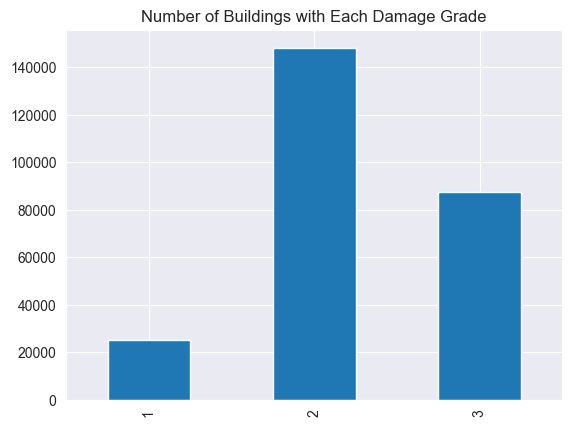

In [61]:
# explore the data
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

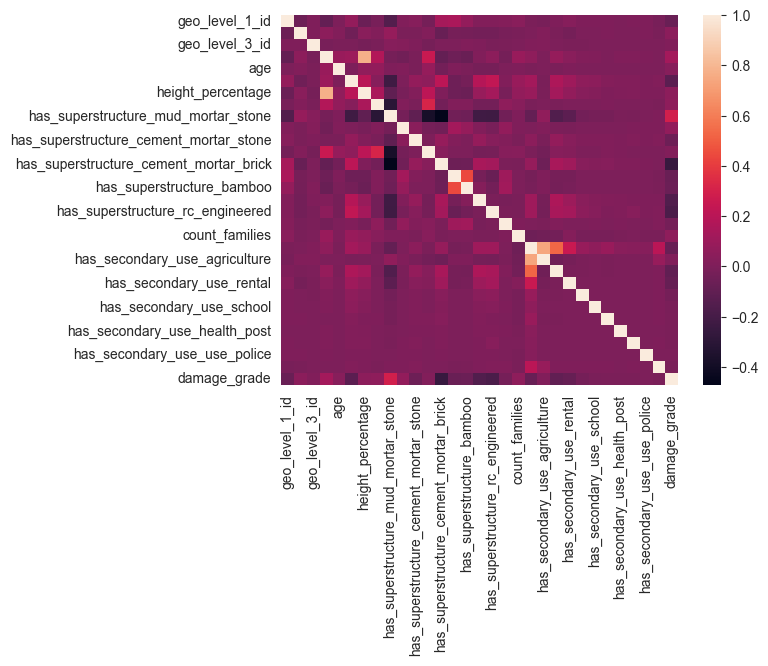

In [62]:
# a quick look at the relationships between our numeric features and labels
sns.heatmap(train_values.join(train_labels).corr(), annot=False, fmt=".2f")
plt.show()

In [63]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining to preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

In [64]:
# select features and preprocess the data
selected_features = ['age',
                     'geo_level_1_id',
                     'geo_level_2_id',
                     'geo_level_3_id',
                     'area_percentage',
                     'height_percentage',
                     'ground_floor_type',
                     'roof_type',
                     'other_floor_type',
                     'position',
                     'foundation_type',
                     'area_percentage',
                     'height_percentage',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_cement_mortar_stone',
                     'has_superstructure_mud_mortar_brick',
                     'count_families',
                     'has_secondary_use',
                     'plan_configuration']

# select the subset of features we used to train the model and create dummy variables.
#train_values_subset = train_values
train_values_subset = train_values[selected_features]
train_values_subset = pd.get_dummies(train_values_subset)
train_values_subset.info()

# select test values
#test_values_subset = test_values
test_values_subset = test_values[selected_features]
test_values_subset = pd.get_dummies(test_values_subset)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 47 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   age                                     260601 non-null  int64
 1   geo_level_1_id                          260601 non-null  int64
 2   geo_level_2_id                          260601 non-null  int64
 3   geo_level_3_id                          260601 non-null  int64
 4   area_percentage                         260601 non-null  int64
 5   height_percentage                       260601 non-null  int64
 6   area_percentage                         260601 non-null  int64
 7   height_percentage                       260601 non-null  int64
 8   count_floors_pre_eq                     260601 non-null  int64
 9   has_superstructure_cement_mortar_stone  260601 non-null  int64
 10  has_superstructure_mud_mortar_brick     260601 non-null  int64


In [65]:
# training pipeline
pipe = make_pipeline(StandardScaler(),
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2018))])

In [66]:
# hyperparameter search
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)
gs.fit(train_values_subset, train_labels.values.ravel())
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 50}

In [67]:
# calculate train F1 micro score
from sklearn.metrics import f1_score

in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.765000901761697

In [68]:
# make prediction
predictions = gs.predict(test_values_subset)

# save submission
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [69]:
# save to submission
my_submission.to_csv('submission.csv')
# check the head of the saved file
!type submission.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,2
896100,3
343471,2
766647,2
800548,2
652685,2
590834,2
612530,3
535718,2
269418,2
281421,2
797571,2
216579,2
81554,2
132785,2
976125,3
851237,3
322922,3
786774,2
922680,2
134349,3
551456,2
194812,2
520031,3
765502,3
517764,2
174470,2
395012,2
159776,2
62638,2
65760,2
761527,2
37201,2
853163,2
562505,2
349010,3
780817,2
179897,2
845103,2
171560,2
586661,2
84102,2
610806,3
269531,2
3781,2
127674,2
820462,2
955190,2
405557,2
143219,3
360041,2
378036,2
613583,3
992040,2
849585,2
491236,3
847580,3
229211,3
173624,2
642562,2
86467,2
684629,2
304627,2
255913,3
861624,2
367328,1
13216,2
838446,3
981040,2
335849,2
823769,2
666855,2
398783,2
829946,2
326177,3
359387,2
924578,2
712624,2
946541,2
373943,2
865274,1
522404,2
841632,3
649142,2
332157,1
722082,1
279597,2
107512,2
26477,2
138895,2
553866,2
157718,3
582842,3
123399,2
189875,2
70843,1
225218,2
703273,2
245176,3
760257,2
641933,2
76772,2
302226,2
535232,